In [11]:
import json 
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import folium
import seaborn as sns 
import numpy as np
from geopy.geocoders import Nominatim
from matplotlib.ticker import MultipleLocator

In [3]:
## Reading in data file (takes a minute to run)

events = pd.read_csv("NYC_permitted_event_data.csv")
events.head()


,Event ID,Event Name,Start Date/Time,End Date/Time,Event Agency,Event Type,Event Borough,Event Location,Event Street Side,Street Closure Type,Community Board,Police Precinct
0,368421.0,Big Apple Circus,11/18/2017 07:00:00 PM,11/18/2017 08:00:00 PM,Parks Department,Special Event,Manhattan,"Damrosch Park: Damrosch Park ,Damrosch Park: T...",NaN,NaN,"7,","20,"
1,330050.0,Mt. Eden Farmer's Market,11/16/2017 08:00:00 AM,11/16/2017 04:00:00 PM,Parks Department,Special Event,Bronx,Mount Eden Malls: Mount Eden Malls,NaN,NaN,"4,","44,"
2,314111.0,Columbia Greenmarket Thursday,11/21/2017 08:00:00 AM,11/21/2017 05:00:00 PM,Street Activity Permit Office,Farmers Market,Manhattan,BROADWAY between WEST 114 STREET and WEST 1...,East,Sidewalk and Curb Lane Closure,"9,","26,"
3,369850.0,Lawn Maintenance,11/23/2017 12:00:00 AM,11/23/2017 11:58:00 PM,Parks Department,Construction,Manhattan,Madison Square Park: Center Lawn,NaN,NaN,"5,","13,"
4,335783.0,"October, November December model aircraft flying",11/22/2017 09:00:00 AM,11/22/2017 08:00:00 PM,Parks Department,Special Event,Staten Island,LaTourette Park & Golf Course: Model Airplane ...,NaN,NaN,"2,","122,"


### Cleaning Data ###
##### Dropping Irrelavent Columns, Removing Irrelavent Event Types, Removing Duplicated Rows, Aggregating By Month #####

In [4]:
## dropping last three columns (irrelavent)
events = events.drop(columns=['Event Street Side','Street Closure Type','Community Board','Police Precinct'])

print(len(events))

25980794


In [5]:
## removing the following event types: construction, clean up, mobile unit
events = events[~events['Event Type'].isin(['Construction', 'Clean Up','Mobile Unit'])]
events.reset_index(drop=True, inplace=True)
print(len(events))

25750454


In [6]:
## removing duplicated rows 
events = events.drop_duplicates(subset=['Event ID', 'Start Date/Time', 'End Date/Time','Event Location'], keep='first').reset_index(drop=True)
print(len(events)) # -24 million rows

1594128


In [7]:
## Aggregating Data By Month ## 

# convert datetime_local col to datetime data type
events['Start Date/Time'] = pd.to_datetime(events['Start Date/Time'],format='%m/%d/%Y %I:%M:%S %p')
events['End Date/Time'] = pd.to_datetime(events['End Date/Time'],format='%m/%d/%Y %I:%M:%S %p')

# Extract Year and Month
events['year'] = events['Start Date/Time'].dt.year
events['month'] = events['Start Date/Time'].dt.strftime('%B')  # Full month name

# Define the correct month order for sorting
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Convert 'month' column to categorical with the correct order
events['month'] = pd.Categorical(events['month'], categories=month_order, ordered=True)

# Aggregate by Year and Month
monthly_aggregate = events.groupby(['year', 'month'])['Event ID'].count().reset_index()

# Sort for better readability
monthly_aggregate = monthly_aggregate.sort_values(['year'])

# change year col from float to int
monthly_aggregate['year'] = monthly_aggregate['year'].astype(int)

# add col for year + month
monthly_aggregate['month_year'] = monthly_aggregate['month'].astype(str).str.zfill(2) + '_' + monthly_aggregate['year'].astype(str)

monthly_aggregate_export = monthly_aggregate[['month_year','Event ID']]

monthly_aggregate_export = monthly_aggregate_export[72:204]
monthly_aggregate_export

C:\Users\claro\AppData\Local\Temp\ipykernel_24076\3699617379.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_aggregate = events.groupby(['year', 'month'])['Event ID'].count().reset_index()


,month_year,Event ID
72,January_2014,639
73,February_2014,577
74,March_2014,782
75,April_2014,1877
76,May_2014,3946
...,...,...
199,August_2024,32128
200,September_2024,26098
201,October_2024,28310
202,November_2024,17415


In [8]:
## export the monthly_aggregate_events to csv

monthly_aggregate_export.to_csv("events_monthly_aggregate.csv", index=False) 
monthly_aggregate_export

,month_year,Event ID
72,January_2014,639
73,February_2014,577
74,March_2014,782
75,April_2014,1877
76,May_2014,3946
...,...,...
199,August_2024,32128
200,September_2024,26098
201,October_2024,28310
202,November_2024,17415


### Visualizing Data ### 

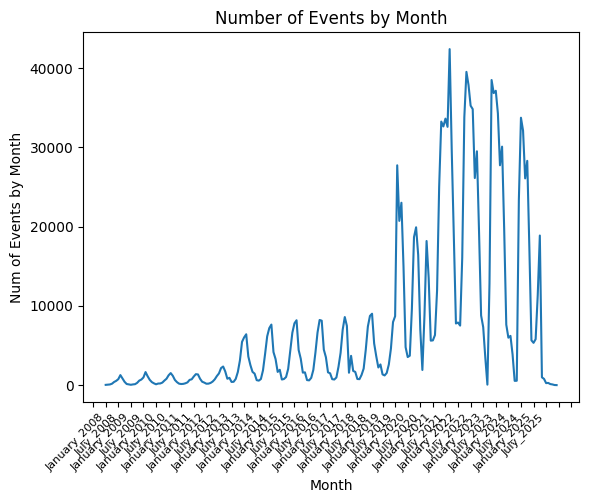

In [20]:
## Number of Events Aggregated by Month ## 

fig, ax = plt.subplots()
plt.plot(monthly_aggregate['month_year'], monthly_aggregate['Event ID'])
plt.xlabel('Month')
plt.ylabel('Num of Events by Month')
plt.title('Number of Events by Month') 
plt.xticks(rotation=45, ha='right'), 
# Set x-axis to show every 3rd tick
ax.xaxis.set_major_locator(MultipleLocator(6))
ax.tick_params(axis='x', which='major', labelsize=8)  # 8 is the font size
plt.show()

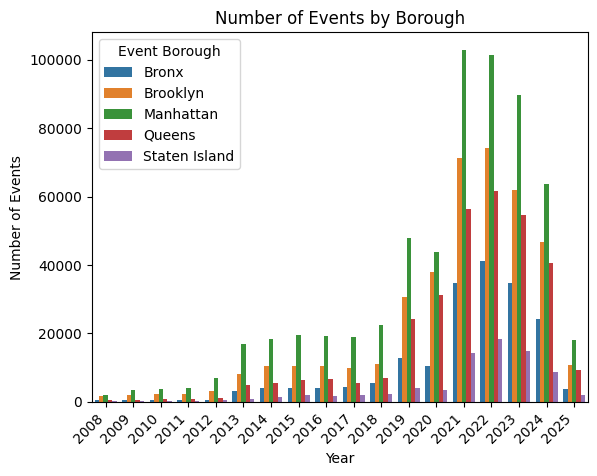

In [ ]:
## Number of events by borough every year ## 

# aggregating number of events by borough for every year
yearly_aggregate_borough = events.groupby(['year','Event Borough'])['Event ID'].count().reset_index()
# Sort for better readability
yearly_aggregate_borough = yearly_aggregate_borough.sort_values(['year'])
# change year col from float to int
yearly_aggregate_borough['year'] = yearly_aggregate_borough['year'].astype(int)

sns.barplot(yearly_aggregate_borough,x='year',y='Event ID',hue='Event Borough')

plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.title('Number of Events by Borough')
plt.xticks(rotation=45, ha='right') 
plt.show()

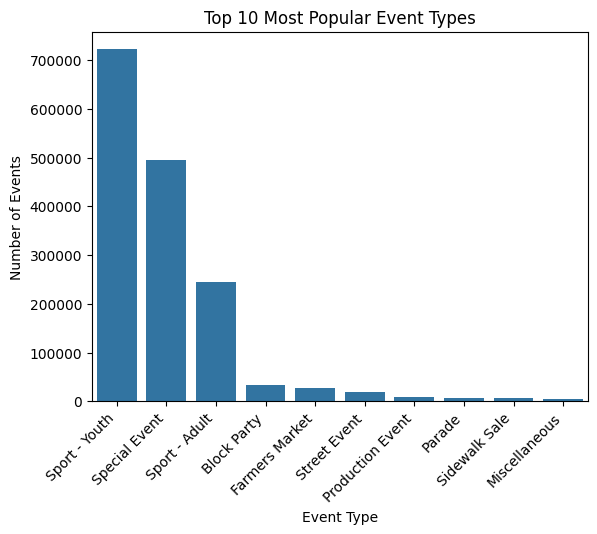

In [ ]:
## Visualizing Most Common Event Types ## 

# TO WORK: FIGURE OUT HOW TO LIMIT TOP 3 or 5 EVENT TYPES PER YEAR
# # aggregating events by event type AND Year
# event_type_aggregate_year = events.groupby(['year','Event Type'])['Event ID'].count().reset_index()
# # Sort for better readability
# event_type_aggregate_year = event_type_aggregate_year.sort_values(['year'])
# # change year col from float to int
# event_type_aggregate_year['year'] = event_type_aggregate_year['year'].astype(int)

# sns.barplot(event_type_aggregate,x='year',y='Event ID',hue='Event Type')

# plt.xlabel('Year')
# plt.ylabel('Number of Events')
# plt.title('Number of Events by Borough')
# plt.show()

# Aggregating events via ONLY event type
event_type_aggregate = events.groupby(['Event Type'])['Event ID'].count().reset_index()
# limit to top 10 event types
event_type_aggregate = event_type_aggregate.sort_values(['Event ID'],ascending=False)
event_type_aggregate_top_10 = event_type_aggregate.head(10)

sns.barplot(event_type_aggregate_top_10,x='Event Type',y='Event ID')

plt.xlabel('Event Type')
plt.ylabel('Number of Events')
plt.title('Top 10 Most Popular Event Types')
plt.xticks(rotation=45, ha='right')
plt.show()
